<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/HOML_Exercise_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
print(len(X_train),len(X_valid), len(X_test))

55000 5000 10000


# A

In [5]:
#텐서를 데이터셋으로
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

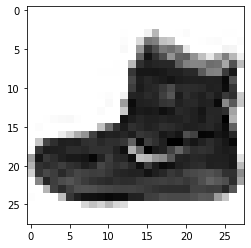

In [27]:
for image, label in valid_set.take(1):
    plt.imshow(image.numpy(), cmap='binary')

In [11]:
#샘플하나를 직렬화하고, byte로 Example 객체에 저장한다.
from tensorflow.train import BytesList, Int64List
from tensorflow.train import Feature, Features, Example
def create_example_protoc(image, label):
    serialized_image = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image" : Feature(bytes_list=BytesList(value=[serialized_image.numpy()])),
                "label" : Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

for image, label in valid_set.take(1):
    print(create_example_protoc(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [21]:
!mkdir tfrecords

from contextlib import ExitStack
def write_tfrecords(fname, dataset, n_shards=10): #파일 조각 개수
    paths = ["tfrecords/{}.tfrecord-{:05d}-{:05d}".format(fname, index, n_shards) for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            #데이터 샘플 10개씩 파일조각 10개에 반복해서 넣음
            shard = index % n_shards #shard => 0 ~ 9 반복
            example = create_example_protoc(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

mkdir: cannot create directory ‘tfrecords’: File exists


In [23]:
print(train_filepaths[0], valid_filepaths[0], test_filepaths[0], sep='\n')

tfrecords/my_fashion_mnist.train.tfrecord-00000-00010
tfrecords/my_fashion_mnist.valid.tfrecord-00000-00010
tfrecords/my_fashion_mnist.test.tfrecord-00000-00010


# B

In [32]:
#tfrecord -> image reshape, label 반환
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=0)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example['label']

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

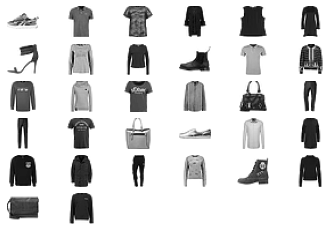

In [40]:
for X, y in train_set.take(1):
    for i, (image, label) in enumerate(zip(X, y)):
        plt.subplot(6, 6, i+1)
        plt.imshow(image.numpy(), cmap='binary')
        plt.axis("off")
        #plt.title(str(y[label].numpy()))